In [54]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import pandas as pd
import sklearn
from utils import *
from models.MNL import *
from models.Cnn import *
import matplotlib.pyplot as plt
from models.resnet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from torch.optim.lr_scheduler import MultiStepLR

%matplotlib inline
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# usps dataset from SVHN
from scipy.io import loadmat
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

svhn_X_tr, svhn_y_tr = load_data('./data/svhn/train_32x32.mat')
svhn_X_test, svhn_y_test = load_data('./data/svhn/test_32x32.mat')
svhn_X_tr, svhn_y_tr = svhn_X_tr.transpose((3,0,1,2)).reshape(svhn_X_tr.shape[3],-1)/255.0, svhn_y_tr[:,0]

# svhn_X_tr, svhn_y_tr = svhn_X_tr.transpose((3,0,1,2))/255.0, svhn_y_tr[:,0]
# from sklearn.preprocessing import normalize
# svhn_X_tr = svhn_X_tr / np.linalg.norm(svhn_X_tr)
print(svhn_X_tr.shape)
svhn_X_test, svhn_y_test = svhn_X_test.transpose((3,0,1,2)).reshape(26032,-1)/255.0, svhn_y_test[:,0]

# print(type(svhn_X_train))
for i in range(len(svhn_y_tr)):
    if(svhn_y_tr[i] == 10):
        svhn_y_tr[i] = 0
for i in range(len(svhn_y_test)):
    if(svhn_y_test[i] == 10):
        svhn_y_test[i] = 0    

print("Training Set", svhn_X_tr.shape, svhn_y_tr.shape)
print("Test Set", svhn_X_test.shape, svhn_y_test.shape)

(73257, 3072)
Training Set (73257, 3072) (73257,)
Test Set (26032, 3072) (26032,)


5


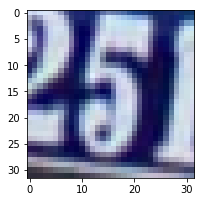

In [64]:
t_idx = 88
print(svhn_y_tr[t_idx])
pic_n = 1
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(svhn_X_tr[t_idx].reshape([32, 32, 3]), 'gray')

In [65]:
data = MNIST(one_hot=False, shuffle=False)
X_tr, mnist_y_tr = data.x_train, data.y_train
X_te, mnist_y_te = data.x_test, data.y_test

mnist_X_tr = [[] for i in range(len(X_tr))]
mnist_X_te = [[] for i in range(len(X_te))]
dim = np.zeros((28,28))

for i in range(len(X_tr)):
    temp = np.array(X_tr[i].reshape(28,28))
    temp = np.stack((temp, dim, dim), axis=2)
    temp = cv2.resize(temp, (32, 32), interpolation=cv2.INTER_CUBIC)
    mnist_X_tr[i] = temp.flatten()


for i in range(len(X_te)):
    temp = np.array(X_te[i].reshape(28,28))
    temp = np.stack((temp, dim, dim), axis=2)
    temp = cv2.resize(temp, (32, 32), interpolation=cv2.INTER_CUBIC)
    mnist_X_te[i] = temp.flatten()

mnist_X_tr = np.array(mnist_X_tr) 
mnist_X_te = np.array(mnist_X_te)
print(np.array(mnist_X_tr).shape, np.array(mnist_X_te).shape)
print("Training Set", svhn_X_tr.shape, svhn_y_tr.shape)
# print("Test Set", svhn_X_test.shape, svhn_y_test.shape)

(60000, 3072) (10000, 3072)
Training Set (73257, 3072) (73257,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


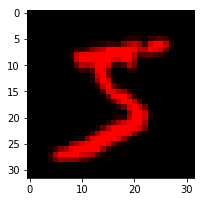

In [66]:
size=32
img = np.array(mnist_X_tr[0].reshape(32,32, 3))
res = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
print(res.shape)
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(res)

In [67]:
# print(svhn_y_train[:1000])

In [68]:
# data = MNIST(one_hot=False, shuffle=False)
# data.x_train[:700] = add_noise(data.x_train[:700], 1, 0.1, 'white')
# import torchvision.models as models
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True
torch.cuda.manual_seed(seed)

# Hyper Parameters 
input_size = 32*32*3
num_classes = 10
batch_size = 128
epochs = 15
learning_rate = 0.01
train_size = 2000
test_size = 2000

device = torch.device('cuda')
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[80, 120], gamma=0.1)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.9)

mnist_x_train = torch.from_numpy(mnist_X_tr[:test_size]).contiguous().view(-1, 3, 32, 32)
mnist_y_train = torch.from_numpy(mnist_y_tr[:test_size]).view(-1,).long()
# print("train_size:", y_train.shape)

mnist_x_test = torch.from_numpy(mnist_X_te[:train_size]).contiguous().view(-1, 3, 32, 32)
mnist_y_test = torch.from_numpy(mnist_y_te[:train_size]).view(-1,).long()
print("test_size:", y_test.shape)

svhn_x_train = torch.from_numpy(svhn_X_tr[:train_size]).contiguous().view(-1, 3, 32, 32)
svhn_y_train = torch.from_numpy(svhn_y_tr[:train_size]).view(-1,).long()
svhn_x_test = torch.from_numpy(svhn_X_test[:test_size]).contiguous().view(-1, 3, 32, 32)
svhn_y_test = torch.from_numpy(svhn_y_test[:test_size]).view(-1,).long()



train(model, device, svhn_x_train, svhn_y_train, batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(model, device, svhn_x_train, svhn_y_train, batch_size, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

accuracy, avg_loss = evaluate(model, device, x_test, y_test, batch_size, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

test_size: torch.Size([2000])



[Train] Accuracy: 88.60%, loss:  0.0063
[Test] Accuracy:  9.65%, loss:  0.0208


In [69]:
deep_f_train = []
deep_f_test = []
targets = []
for X, y in batch(svhn_x_train, svhn_y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = model(X)
    deep_f_train.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

for X, y in batch(mnist_x_train, mnist_y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = model(X)
    deep_f_test.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

deep_f_train = np.concatenate(deep_f_train) # deep features are not normalized
deep_f_test = np.concatenate(deep_f_test) # deep features are not normalized
print(deep_f_train.shape, deep_f_test.shape) 

(2000, 512) (2000, 512)


In [70]:
import math
kmin = 1
kmax = 10
kinterval = 1
fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features
loo_fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features

for i, k in enumerate(range(kmin, kmax, kinterval)):
    
#     fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f[:train_data.shape[0]], deep_f[train_data.shape[0]:], 
#                                   y_deep[:train_data.shape[0]], y_deep[train_data.shape[0]:])
#     loo_fc1_knn_values[i],*_ = loo_knn_shapley(k, deep_f[:train_data.shape[0]], deep_f[train_data.shape[0]:], 
#                                   y_deep[:train_data.shape[0]], y_deep[train_data.shape[0]:])
    loo_fc1_knn_values[i], score, *_ = loo_knn_shapley(k, deep_f_train, deep_f_test, svhn_y_train, mnist_y_train)
    print("neighbour number:", k, score)
    fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f_train, deep_f_test, svhn_y_train, mnist_y_train)

neighbour number: 1 0.081


neighbour number: 2 0.0235


neighbour number: 3 0.0455


neighbour number: 4 0.025


neighbour number: 5 0.0405


neighbour number: 6 0.024


neighbour number: 7 0.0305


neighbour number: 8 0.0225


neighbour number: 9 0.027


In [71]:
# print(len(knn_values[1][0]))

(1771,)
(14,)
(1772,)
(17,)
(1771,)
(23,)
(1773,)
(30,)
(1774,)
(27,)
(1776,)
(37,)
(1777,)
(44,)
(1777,)
(49,)
(1778,)
(47,)


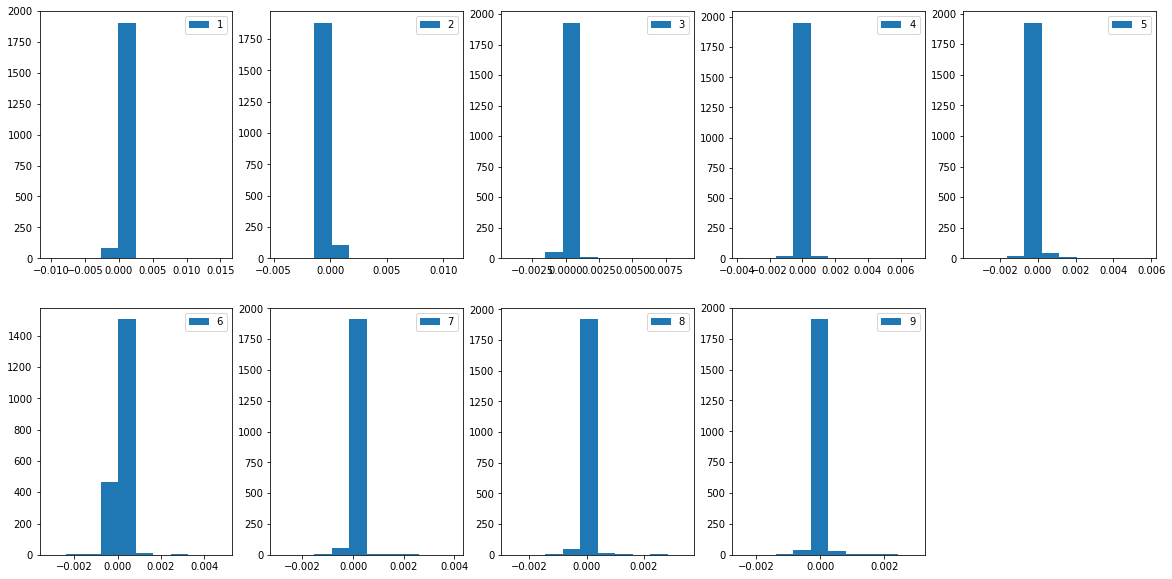

In [72]:
import pandas as pd
pd.options.display.max_columns = None
from IPython.display import display
class_weights = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
knn_values_idx = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
knn_values_advanced = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
loo_knn_values_idx = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
loo_knn_values_advanced = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]

#removing negative data
for i in range(len(fc1_knn_values)):
#     print(i)
    knn_values_idx[i] = np.where(fc1_knn_values[i] > 0)[0]
    knn_values_advanced[i] = fc1_knn_values[i][np.where(fc1_knn_values[i] > 0)[0]]
    print(knn_values_idx[i].shape)
    loo_knn_values_idx[i] = np.where(loo_fc1_knn_values[i] > 0)[0]
    loo_knn_values_advanced[i] = loo_fc1_knn_values[i][np.where(loo_fc1_knn_values[i] > 0)[0]]
    print(loo_knn_values_idx[i].shape)

#     for j in range(train_size):
#         if(fc1_knn_values[i][j]>0):
#             class_weights[i][targets[j]] += fc1_knn_values[i][j]

# for i in range(len(class_weights)):
#     print(class_weights[i])
fig=plt.figure(figsize=(20, 10))
for i, k in enumerate(range(kmin, kmax, kinterval)):
#     print(i,k)
    fig.add_subplot( 2, 5, i+1)
    plt.hist(fc1_knn_values[i].astype('float'), label=k)
    plt.legend()
plt.show()

In [73]:
print(mnist_X_te.shape, mnist_y_te.shape)
test_learning_rate = learning_rate
seed = 48
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True

for i, k in enumerate(range(kmin, kmax, kinterval)):
    print("K=", k)
    device = torch.device('cuda')
    model = ResNet18(num_classes=10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=test_learning_rate)
    criterion = nn.CrossEntropyLoss()

    x_train_val, y_train_val = svhn_x_train[knn_values_idx[i]], svhn_y_train[knn_values_idx[i]]
    print(x_train_val.shape, y_train_val.shape)
    
    train(model, device, x_train_val, y_train_val, batch_size, optimizer, criterion, epochs)
    accuracy, avg_loss = evaluate(model, device, x_test, y_test, batch_size, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    
    model = ResNet18(num_classes=10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=test_learning_rate)
    criterion = nn.CrossEntropyLoss()

    x_train_val, y_train_val = svhn_x_train[loo_knn_values_idx[i]], svhn_y_train[loo_knn_values_idx[i]]
    print(x_train_val.shape, y_train_val.shape)
    
    train(model, device, x_train_val, y_train_val, batch_size, optimizer, criterion, epochs)
    accuracy, avg_loss = evaluate(model, device, x_test, y_test, batch_size, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

(10000, 3072) (10000,)
K= 1
torch.Size([1771, 3, 32, 32]) torch.Size([1771])



[Test] Accuracy:  9.20%, loss:  0.0351
torch.Size([14, 3, 32, 32]) torch.Size([14])



[Test] Accuracy: 11.70%, loss:  0.0185
K= 2
torch.Size([1772, 3, 32, 32]) torch.Size([1772])



[Test] Accuracy: 15.90%, loss:  0.0235
torch.Size([17, 3, 32, 32]) torch.Size([17])



[Test] Accuracy: 11.70%, loss:  0.0185
K= 3
torch.Size([1771, 3, 32, 32]) torch.Size([1771])



[Test] Accuracy: 20.25%, loss:  0.0237
torch.Size([23, 3, 32, 32]) torch.Size([23])



[Test] Accuracy: 11.70%, loss:  0.0187
K= 4
torch.Size([1773, 3, 32, 32]) torch.Size([1773])



[Test] Accuracy: 14.35%, loss:  0.0275
torch.Size([30, 3, 32, 32]) torch.Size([30])



[Test] Accuracy: 11.70%, loss:  0.0186
K= 5
torch.Size([1774, 3, 32, 32]) torch.Size([1774])



[Test] Accuracy: 17.50%, loss:  0.0260
torch.Size([27, 3, 32, 32]) torch.Size([27])



[Test] Accuracy: 11.70%, loss:  0.0186
K= 6
torch.Size([1776, 3, 32, 32]) torch.Size([1776])



[Test] Accuracy: 11.40%, loss:  0.0228
torch.Size([37, 3, 32, 32]) torch.Size([37])



[Test] Accuracy: 10.85%, loss:  0.0187
K= 7
torch.Size([1777, 3, 32, 32]) torch.Size([1777])



[Test] Accuracy: 15.95%, loss:  0.0323
torch.Size([44, 3, 32, 32]) torch.Size([44])



[Test] Accuracy: 11.70%, loss:  0.0186
K= 8
torch.Size([1777, 3, 32, 32]) torch.Size([1777])



[Test] Accuracy: 11.10%, loss:  0.0215
torch.Size([49, 3, 32, 32]) torch.Size([49])



[Test] Accuracy: 11.70%, loss:  0.0186
K= 9
torch.Size([1778, 3, 32, 32]) torch.Size([1778])



[Test] Accuracy: 11.35%, loss:  0.0289
torch.Size([47, 3, 32, 32]) torch.Size([47])



[Test] Accuracy:  9.60%, loss:  0.0186
